In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import scipy.io
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time
from sklearn.neighbors import NearestNeighbors

### load data

In [3]:
mat = scipy.io.loadmat('../datasets/fashion.mat')

In [4]:
X_train = mat['Xtr']
y_train = mat['ytr']
X_test = mat['Xtst']
y_test = mat['ytst']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

### 1. nearest centroid classification with original images (no pca yet)

In [5]:
clf = NearestCentroid()
clf.fit(X_train, y_train.ravel())

y_pred = clf.predict(X_test)

print('error = ', 1- accuracy_score(y_test,y_pred))

error =  0.32320000000000004


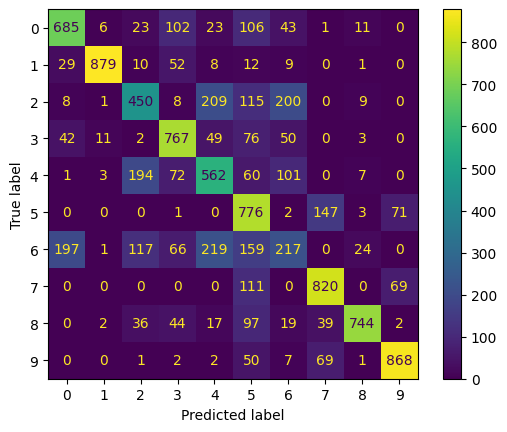

In [6]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot();

### 2. Apply PCA to reduce dimension first and then perform k nearest neighbor (kNN) classification (Euclidean distance, no weighting).

For this data set, 50 dimensions might no longer be the best choice. So there are two parameters to be tuned: m (number of pca dimensions) and k (number of nearest neighbors).

A large scale grid search over (m,k) could find the optimal pair in terms of test error (or validation error). However, it will be slow.

Here, let us fix m to a small number of values such as 50, 100, 150 (feel free to change these numbers). For each value of m, perform PCA to project both the training and test data into the same m dimensional space. Afterwards, perform kNN classification on the m-dimensional PCA reduced data, for k = 1, 2, ..., 12. Plot the test errors against k, one curve for each fixed value of m.

What is a good choice of the pair (m,k), in terms of test error?

In [7]:
m_values = [50, 100, 150, 200]
k_values = range(1, 13)

errors = {}

for m in m_values:
    pca = PCA(n_components=m)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train_pca, y_train.ravel())
        y_pred = clf.predict(X_test_pca)
        errors[(m, k)] = 1 - accuracy_score(y_test, y_pred)
        print('m =', m, 'k =', k, 'error =', errors[(m, k)])

best_params = min(errors, key=errors.get)
print('best_params =', best_params)
print('error =', errors[best_params])

m = 50 k = 1 error = 0.15790000000000004
m = 50 k = 2 error = 0.1582
m = 50 k = 3 error = 0.1481
m = 50 k = 4 error = 0.14239999999999997
m = 50 k = 5 error = 0.14349999999999996
m = 50 k = 6 error = 0.14139999999999997
m = 50 k = 7 error = 0.14170000000000005
m = 50 k = 8 error = 0.14180000000000004
m = 50 k = 9 error = 0.1431
m = 50 k = 10 error = 0.14159999999999995
m = 50 k = 11 error = 0.1421
m = 50 k = 12 error = 0.14339999999999997
m = 100 k = 1 error = 0.15149999999999997
m = 100 k = 2 error = 0.15039999999999998
m = 100 k = 3 error = 0.13959999999999995
m = 100 k = 4 error = 0.13759999999999994
m = 100 k = 5 error = 0.13729999999999998
m = 100 k = 6 error = 0.13580000000000003
m = 100 k = 7 error = 0.13980000000000004
m = 100 k = 8 error = 0.13780000000000003
m = 100 k = 9 error = 0.139
m = 100 k = 10 error = 0.13880000000000003
m = 100 k = 11 error = 0.14129999999999998
m = 100 k = 12 error = 0.1401
m = 150 k = 1 error = 0.14739999999999998
m = 150 k = 2 error = 0.14800000000

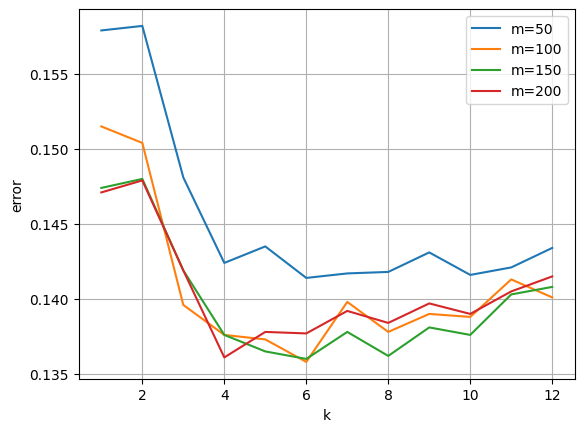

In [8]:
# Plot all lines for each m, k pair

for m in m_values:
    plt.plot(k_values, [errors[(m, k)] for k in k_values], label=f'm={m}')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.show()

In [9]:
best_m = best_params[0]
best_m

100

### 3 For the best value of m found above, perform unweighted kNN classification with city block distance ($\ell_1$) for k = 1,2,..., 12. 

Plot the test errors against k. How does it compare with unweighted kNN + Euclidean metric ($\ell_2$)?

In [10]:
k_values = range(1, 13)

manhatten_errors = []
euclidean_errors = []

pca = PCA(n_components=best_m)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    manhatten_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Manhattan: m =', best_m, 'k =', k, 'error =', manhatten_errors[k-1])

    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    euclidean_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Euclidean: m =', best_m, 'k =', k, 'error =', euclidean_errors[k-1])

Manhattan: m = 100 k = 1 error = 0.14649999999999996
Euclidean: m = 100 k = 1 error = 0.15149999999999997
Manhattan: m = 100 k = 2 error = 0.14680000000000004
Euclidean: m = 100 k = 2 error = 0.15039999999999998
Manhattan: m = 100 k = 3 error = 0.136
Euclidean: m = 100 k = 3 error = 0.13959999999999995
Manhattan: m = 100 k = 4 error = 0.13429999999999997
Euclidean: m = 100 k = 4 error = 0.13759999999999994
Manhattan: m = 100 k = 5 error = 0.13470000000000004
Euclidean: m = 100 k = 5 error = 0.13729999999999998
Manhattan: m = 100 k = 6 error = 0.13249999999999995
Euclidean: m = 100 k = 6 error = 0.13580000000000003
Manhattan: m = 100 k = 7 error = 0.13360000000000005
Euclidean: m = 100 k = 7 error = 0.13980000000000004
Manhattan: m = 100 k = 8 error = 0.13460000000000005
Euclidean: m = 100 k = 8 error = 0.13780000000000003
Manhattan: m = 100 k = 9 error = 0.13590000000000002
Euclidean: m = 100 k = 9 error = 0.139
Manhattan: m = 100 k = 10 error = 0.1361
Euclidean: m = 100 k = 10 error =

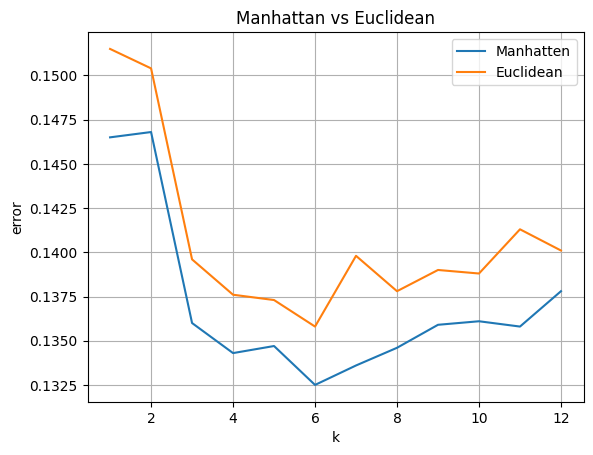

In [11]:
plt.plot(k_values, manhatten_errors, label='Manhatten')
plt.plot(k_values, euclidean_errors, label='Euclidean')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Manhattan vs Euclidean')
plt.show()

### 4. For the best value of m found above, perform kNN classification + Euclidean metric, with inverse distance weights, for k = 1,2,...,12. 

Plot the test errors against k.  How does the weighted kNN compare with the unweighted kNN (both with Euclidean metric)

In [12]:
inverse_errors = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    clf.fit(X_train_pca, y_train.ravel())
    y_pred = clf.predict(X_test_pca)
    inverse_errors.append(1 - accuracy_score(y_test, y_pred))
    print('Inverse: m =', best_m, 'k =', k, 'error =', inverse_errors[k-1])

Inverse: m = 100 k = 1 error = 0.15149999999999997
Inverse: m = 100 k = 2 error = 0.15149999999999997
Inverse: m = 100 k = 3 error = 0.13890000000000002
Inverse: m = 100 k = 4 error = 0.1361
Inverse: m = 100 k = 5 error = 0.1351
Inverse: m = 100 k = 6 error = 0.136
Inverse: m = 100 k = 7 error = 0.13839999999999997
Inverse: m = 100 k = 8 error = 0.13560000000000005
Inverse: m = 100 k = 9 error = 0.1372
Inverse: m = 100 k = 10 error = 0.135
Inverse: m = 100 k = 11 error = 0.13729999999999998
Inverse: m = 100 k = 12 error = 0.13639999999999997


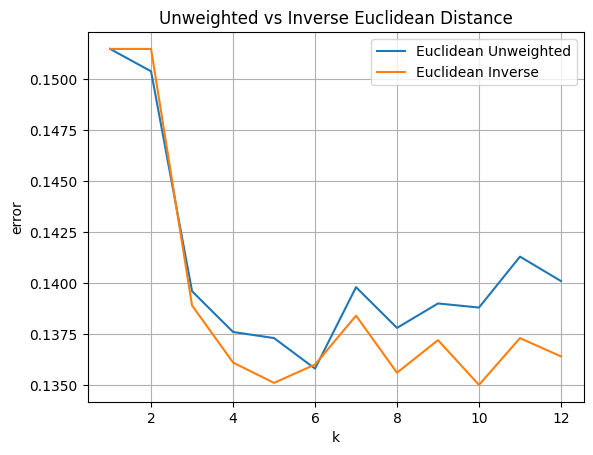

In [13]:
plt.plot(k_values, euclidean_errors, label='Euclidean Unweighted')
plt.plot(k_values, inverse_errors, label='Euclidean Inverse')
plt.legend()
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Unweighted vs Inverse Euclidean Distance')
plt.show()

### 5. Implment the nearest local centroid classifier (with Euclidean distance) and apply it to the m-dimensional PCA reduced data for various values of k. 

Plot the test errors against k.

In [16]:
def individualNLC(X_train,y_train,test,k):
                  
    y_train = y_train.ravel()
    distances = np.zeros((X_train.shape[0],1)).ravel()

    for i in range(X_train.shape[0]):
        distances[i] = np.linalg.norm(X_train[i,:] - test)

    categories = np.unique(y_train)
    max_len = y_train[y_train == statistics.mode(y_train)].shape[0] 
    padded_vectors = []

    for i in categories:

        v = distances[y_train == i]

        # Convert each vector to float and pad with NaN
        padded_v = np.pad(v.astype(float), (0, max_len - len(v)), constant_values=np.nan)
        padded_v.sort()
        padded_vectors.append(padded_v)

    labeled_clusters = np.column_stack(padded_vectors)
    # Take closest k points
    labeled_clusters = labeled_clusters[0:k-1,:]

    # Compute centroids for each cluster
    centroids = np.zeros((categories.shape[0],1)).ravel()
    
    for i in range(categories.shape[0]):
        centroids[i] = np.nanmean(labeled_clusters[:,i])

    # Compute distances between centroids and test point
    centroid_dist = np.zeros((categories.shape[0],2))
    
    for i in range(categories.shape[0]):
        centroid_dist[i,0] = np.linalg.norm(centroids[i] - test)
        centroid_dist[i,1] = categories[i]


    # Sort by the centroid distances and take the corresponding top label
    centroid_dist = centroid_dist[centroid_dist[:, 0].argsort()]
    label = centroid_dist[0,1]
    return label


In [17]:
def NearestLocalCentroid(X_train,y_train,X_test,k):
    
    labels = np.zeros((X_test.shape[0],1)).ravel()
    for i in range(X_test.shape[0]):
        labels[i] = individualNLC(X_train, y_train, X_test[i,:], k)
    
    return labels

In [19]:
y_train = y_train.ravel()

start_time = time.time()

knn = NearestNeighbors(n_neighbors = 12)
array = np.zeros((10000,100,12))
classes = np.zeros((10000,12,10))
X_test_pca_3d = np.repeat(X_test_pca[:, :, np.newaxis], 12, axis=2)

# for each class
for j in range(10):
    X_class = X_train_pca[y_train == j,:] # filter by class
    knn.fit(X_class)
    knn_ind = knn.kneighbors(X_test_pca, return_distance= False) # 
    
    # Create each 3D slice
    for k in range(12):
        array[:,:,k] = X_class[knn_ind[:,k],:] # create a 3d array with slices of the kth neighbor in X_train for each point in X_test
    cumsum = np.cumsum(array, axis=2) # Takes cumulative sum of each slice (1, 1+2, 1+2+3, ..., 1+2+3+...+12)
    
    # Average each slice appropriately to centroids for each value of k
    for k in range(1,13):
        cumsum[:,:,k-1] = (1/k)*cumsum[:,:,k-1]

    # Store distances from centroid for every class
    distances = np.linalg.norm(cumsum - X_test_pca_3d, axis=1) # distance between X_test points and centroids
    classes[:,:,j] = distances[:,:] # store slices for each class in a 3d array 

# Gives each prediction for every value of k
predictions = np.argmin(classes, axis=2) # grabs the index in the third axis of each point (which corresponds to the class)

errors2 = np.zeros((12,1)).ravel()
for k in range(12):
    y_pred = predictions[:,k]
    error = 1 - accuracy_score(y_pred,y_test.ravel())
    errors2[k] = error
print(-(start_time - time.time()))

3.730922222137451


In [ ]:
'''
1. Isolate each class into a new variable
2. Find the 5 closest points in that class to the test point
3. Calculate the centroid of those 5 points
4. Store the distance from the centroid to the test point
5. Repeat for all classes
6. The class with the minimum distance is the predicted class
7. Store the predicted class
8. Repeat for all test points
9. Calculate the error
'''
for k in k_values:
    predicted_classes = []
    classes = np.unique(y_train.ravel())  # Get all unique classes from y_train

    for point in X_test_pca:
        distances = []
        for cls in classes:  # Use manually extracted classes
            X_class = X_train_pca[y_train.ravel() == cls]
            if len(X_class) > 0:
                # Create a temporary classifier for the class subset
                temp_clf = KNeighborsClassifier(n_neighbors=min(5, len(X_class)), metric='euclidean')
                temp_clf.fit(X_class, y_train[y_train.ravel() == cls])
                # Find the closest points in this class to the test point
                five_closest = temp_clf.kneighbors(point.reshape(1, -1), return_distance=False)
                centroid = np.mean(X_class[five_closest.flatten()], axis=0)
                # Compute the distance
                distance = np.linalg.norm(centroid - point)
            else:
                distance = np.inf  # Handle empty classes gracefully
            distances.append(distance)

        if np.all(np.isinf(distances)):
            raise ValueError("All classes are empty. Check your data.")

        # Predict class based on the minimum distance
        predicted_class = classes[np.argmin(distances)]
        predicted_classes.append(predicted_class)

    # Calculate the error
    errors.append(1 - accuracy_score(y_test, predicted_classes))
    print('k =', k, 'error =', errors[-1])

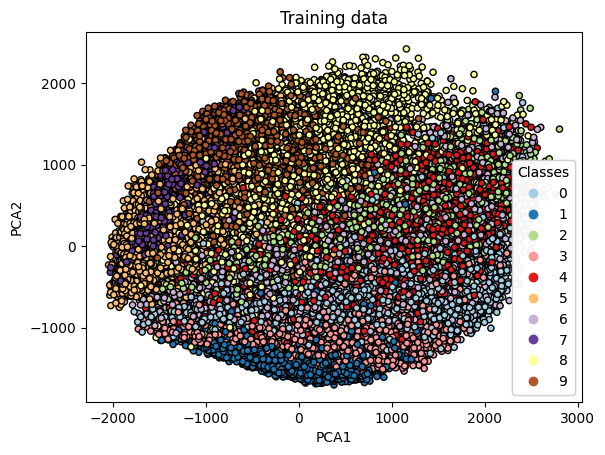

In [20]:
cmap_bold = plt.cm.get_cmap('Paired')
# Create a scatter plot of the training data in the PCA space
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.ravel(), cmap=cmap_bold, edgecolor='k', s=20)

# Create a custom legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Training data')
plt.show()

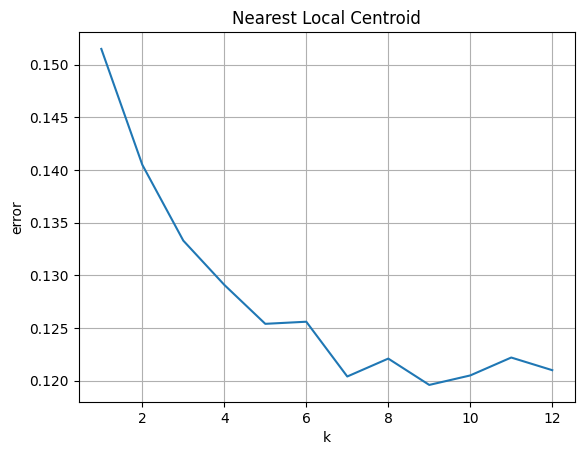

In [23]:
plt.plot(k_values, errors2)
plt.xlabel('k')
plt.ylabel('error')
plt.grid()
plt.title('Nearest Local Centroid')
plt.show()